# SMRT Performance on Test Datasets

### Package Imports

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection as ms
from sklearn import datasets, metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from smrt import smrt_balance
import time 
from matplotlib.legend_handler import HandlerLine2D

seed = 42

## Define Functions for Evaluation

In [2]:
def eval_unbalanced(train_data,label_data):
    start_bal = time.time()
    end_bal = time.time()
    start_fit = time.time()
    rf.fit(train_data,label_data)
    end_fit = time.time()
    preds = rf.predict(X_test)
    cohen_score = metrics.cohen_kappa_score(y_test, preds)
    acc_score = metrics.accuracy_score(y_test, preds)
    auc_score = metrics.roc_auc_score(y_test, preds)
    avg_prec_score = metrics.average_precision_score(y_test, preds)    
    balance_time = (end_bal-start_bal)
    fit_time= (end_fit-start_fit)
    combined_time = ((end_bal-start_bal)+(end_fit-start_fit))
    
    base_scores_dict = {'Cohen Kappa Score':cohen_score,'Accuracy Score':acc_score
                   ,'AUC Score': auc_score, "Average Precision Score":avg_prec_score}
    base_time_dict = {'Balance Time': balance_time,'Fit Time':fit_time,'Combined Time': combined_time}
    return base_scores_dict, base_time_dict

#function for returning evaluation metric and time dictionaries over a range of balance ratios for plotting
def eval_sampler(train_data,label_data,balance_ratio_array):
    balance_array = balance_ratio_array
    cohen_scores = []
    acc_scores = []
    auc_scores = []
    avg_prec_scores = []
    balance_time_list = []
    fit_time_list = []
    combined_time_list =  []


    for i in range(len(balance_arr)):
        start_bal = time.time()
        X_bal, y_bal = smrt_balance(train_data,label_data, seed=seed, shuffle=False, balance_ratio = balance_array[i])
        end_bal = time.time()
        start_fit = time.time()
        rf.fit(X_bal,y_bal)
        end_fit = time.time()
        preds = rf.predict(X_test)
        cohen_scores.append(metrics.cohen_kappa_score(y_test,preds))
        acc_scores.append(metrics.accuracy_score(y_test, preds)) 
        auc_scores.append(metrics.roc_auc_score(y_test, preds))
        avg_prec_scores.append(metrics.average_precision_score(y_test, preds))
        balance_time_list.append(end_bal-start_bal)
        fit_time_list.append(end_fit-start_fit)
        combined_time_list.append((end_bal-start_bal)+(end_fit-start_fit))
    
    scores_dictionary = {'Cohen Kappa Score':cohen_scores,'Accuracy Score':acc_scores
                   ,'AUC Score': auc_scores, "Average Precision Score":avg_prec_scores}
    time_dictionary = {'Balance Time': balance_time_list,'Fit Time':fit_time_list,'Combined Time': combined_time_list}
    return scores_dictionary, time_dictionary

#function for plotting performance mesure information over a range of balance ratios
def plot_performance(eval_score_dictionary,balance_ratio_array):
    plt.figure(1)
    count = 0

    for i in eval_score_dictionary.keys():
        count += 1
        plt.subplot(220+count)
        plt.title("{} Curve with SMITE".format(i))
        plt.xlabel("Balance Ratio")
        plt.ylabel("{}".format(i))
        plt.plot(balance_ratio_array, eval_score_dictionary[i])

    plt.show()

#function for plotting performance mesure information over a range of balance ratios
def plot_performance_comp(eval_score_dictionary,base_score_dictionary,balance_ratio_array):
    plt.figure(1)
    count = 0

    for i in eval_score_dictionary.keys():
        count += 1
        plt.subplot(220+count)
        plt.title("{} Curve with SMITE".format(i))
        plt.xlabel("Balance Ratio")
        plt.ylabel("{}".format(i))
        plt.axhline(y=base_score_dictionary[i], color='r', linestyle='-')
        plt.plot(balance_ratio_array, eval_score_dictionary[i])

    plt.show()

#function for plotting timing information over a range of balance ratios
def plot_time(time_dictionary, balance_ratio_array):
    #function for plotting time
    plt.figure(1)
    count = 0

    for i in time_dictionary.keys():
        count += 1
        plt.subplot(220+count)
        plt.title("{}".format(i))
        plt.xlabel("Balance Ratio")
        plt.ylabel("{}".format(i))
        plt.plot(balance_ratio_array, time_dictionary[i])

    plt.subplot(224)
    bal_line, = plt.plot(balance_ratio_array, time_dictionary['Balance Time'], label='Balance Time')
    fit_line, = plt.plot(balance_ratio_array, time_dictionary['Fit Time'], label='Fit Time')
    combined_line, =plt.plot(balance_ratio_array, time_dictionary['Combined Time'],label='Combined Time')
    plt.legend(handler_map={bal_line: HandlerLine2D(numpoints=4)})

    plt.show()

#function for plotting timing information over a range of balance ratios
def plot_time_comp(eval_time_dictionary, base_time_dictionary,balance_ratio_array):
    #function for plotting time
    plt.figure(1)
    count = 0

    for i in eval_time_dictionary.keys():
        count += 1
        plt.subplot(220+count)
        plt.title("{}".format(i))
        plt.xlabel("Balance Ratio")
        plt.ylabel("{}".format(i))
        plt.axhline(y=base_time_dictionary[i], color='r', linestyle='-')
        plt.plot(balance_ratio_array, eval_time_dictionary[i])

    plt.subplot(224)
    bal_line, = plt.plot(balance_ratio_array, eval_time_dictionary['Balance Time'], label='Balance Time')
    fit_line, = plt.plot(balance_ratio_array, eval_time_dictionary['Fit Time'], label='Fit Time')
    combined_line, =plt.plot(balance_ratio_array, eval_time_dictionary['Combined Time'],label='Combined Time')
    base_combined_time = plt.axhline(y=base_time_dictionary['Combined Time'], color='r', linestyle='-')
    plt.legend(handler_map={bal_line: HandlerLine2D(numpoints=4)})

    plt.show()

### Create an Imbalanced Dataset for Testing

In [3]:
# Generate the dataset
X, y = datasets.make_classification(n_classes=2, class_sep=2,
                                    weights=[.95, .05], n_informative=50,
                                    n_redundant=10, flip_y=0, n_features=100,
                                    n_clusters_per_class=4, n_samples=50000,
                                    random_state=seed)

### Split Dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

### Fit a Model on the un-sampled Dataset

In [5]:
rf = RandomForestClassifier(random_state=seed,n_jobs = -1)

rf.fit(X_train,y_train)

preds = rf.predict(X_test)

### Evaluate Model Performance

In [6]:
print(metrics.classification_report(y_test,preds))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     14238
          1       0.95      0.11      0.19       762

avg / total       0.95      0.95      0.94     15000



In [7]:
cohen_score = metrics.cohen_kappa_score(y_test, preds)
acc_score = metrics.accuracy_score(y_test, preds)
auc_score = metrics.roc_auc_score(y_test, preds)
avg_prec = metrics.average_precision_score(y_test, preds)

print("Cohen Kappa score is {}".format(cohen_score))
print("Accuracy Score is {}".format(acc_score))
print("AUC Score is {}".format(auc_score))
print("Average Precision is {}".format(avg_prec))

Cohen Kappa score is 0.1849986368983051
Accuracy Score is 0.9544
AUC Score is 0.5536653051111974
Average Precision is 0.5532166269913936


## Evaluate Performance of SMRT Oversampling

In [8]:
#pass a range of ratios to evaluate
balance_arr = np.arange(.1,1,.1)

#return the score and time dictionaries for plotting
bal_model_scores, bal_model_times = eval_sampler(X_train,y_train,balance_arr)

#return the score and time dictionaries for plotting base performance
base_scores, base_times = eval_unbalanced(X_train, y_train)

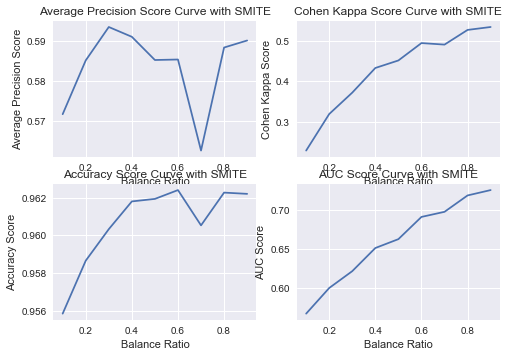

In [9]:
plot_performance(bal_model_scores,balance_arr)

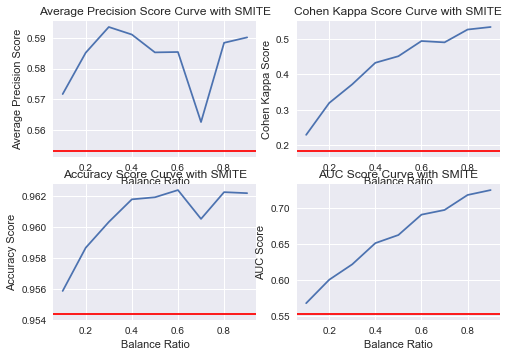

In [10]:
plot_performance_comp(bal_model_scores,base_scores,balance_arr)

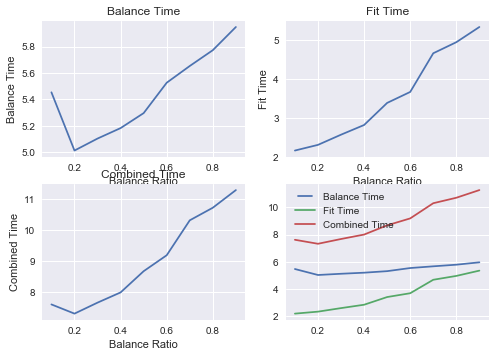

In [11]:
plot_time(bal_model_times, balance_arr)

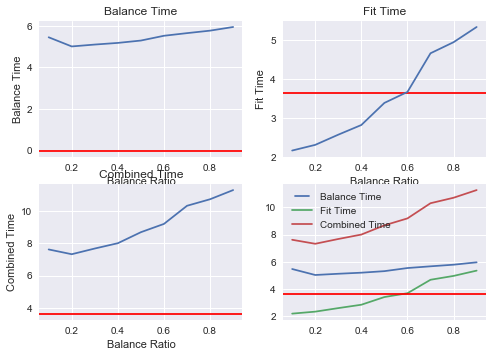

In [12]:
plot_time_comp(bal_model_times,base_times,balance_arr)